In [1]:
!nvidia-smi

Mon Mar 25 16:14:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:B4:00.0 Off |                  N/A |
|  0%   28C    P8              23W / 300W |      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
import json
import accelerate
import wandb
import random
from datasets import Dataset, load_dataset, Features, Value
from PIL import Image
import numpy as np
import cv2
import datasets
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, DataCollatorWithPadding#, AutoImageProcessor, UperNetForSemanticSegmentation

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionInpaintPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor

/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [50]:
import matplotlib.pyplot as plt

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anilbhatt1 (era1). Use `wandb login --relogin` to force relogin


True

In [ ]:
!gdown -q 1JwulCNHgwRGKWEBMmQQ8SvJlfy9jWk8_ # designed_room.zip done
!gdown -q 16_E8EsTI3VINn1TVYnNI3jmJrPvgKm_y # ikea_room_images.zip done
!gdown -q 1MtjZb9WBhPvO0v96jwf5oanHjOccEGw6 # indoorCVPR_09_selected_images.zip done
!gdown -q 1hJS1rbc8AWeuLZa3TXpdHcIDDzEBepE8 # New_styles_data.zip done

!gdown -q 1aFio5tP72_y7Y5fxzZ1soVWh4k75594G # indoorcvpr_clean_image_mask.zip done
!gdown -q 1b60XzJaceVnFSTjE2PLZr7JO_Egt1BZP # indoorcvpr_clean_mask.zip done
!gdown -q 1rvvB8_Ey_CDoKWmFoodudLKU4Vw-5DrU # indoorcvpr_mask_clean_names.jsonl done

!gdown -q 1hpndUQrKsyP76Dw4qgYvkxuRnblCxRPT # newstyle_clean_image_mask.zip done
!gdown -q 19qk5LYTd0rA3WLDAYCKSOdbwpa3vLWCh # newstyle_clean_mask.zip done
!gdown -q 1MjBS4VuuMpNz7OWOPNk3vv-mvStx0J4z # newstyle_mask_clean_names.jsonl done

!gdown -q 1YbXkZbTf_8iF2rB0DF1knuFvWzO7YrpB # pinterest_clean_image_mask.zip done
!gdown -q 1lFVDK-bkqgDhu7Qlwd5WCDiRnFbYzaaX # pinterest_clean_mask.zip done
!gdown -q 1ZI9zRc7AGSJ_P1cb0fSwujE-dD_-3rJk # pinterest_mask_clean_names.jsonl done

!gdown -q 1sbMDOSVXMSGmVJLSL4Mvux0clT-MOrLe # ikea_clean_image_mask.zip done
!gdown -q 1J_fNbjHauI_dfYWkaipCneRwoDpjOf1k # ikea_clean_mask.zip done
!gdown -q 1vt7dWhWnp7ySlct07NdhLlpO6kvwq2t9 # ikea_mask_clean_names.jsonl done

!gdown -q 1dY_prngiKTUyENYRAzTj7N1Fbd49fVRE # kitchen_corrected.json
!gdown -q 16FvGq1BjqZxWWmsxI2xoPhsvA_ZvEZEZ # ikea_room_images_corrected.json
!gdown -q 1PKvHCeWGMPWaO8PElIwQeObkbwIpeCPh # dining_room_corrected.json
!gdown -q 1v9mFF9mZG1hA281zRTlV-329Z0rnUPGi # designed_room_lavanya_output.json
!gdown -q 1iKhQ___bbnnEpJF3JFB4YRomBwdLmQa9 # new_styles2_corrected.json
!gdown -q 1fxhpRYHHy079f7iiBEGkDI6kTmwJGD9b # bedroom_lavanya_output.json
!gdown -q 1A211R60s2rRysfdRVGzOHZXGq5bfySBZ # new_styles1_corrected.json
!gdown -q 1HnM3atWnO4JCJ53ccFJYD4dXGdvBpuvE # bathroom_anil_corrected.json
!gdown -q 16vldKwr7KLZWxTOKeYPPn_I5a9dWxV8a # living_room_anil_corrected.json
!gdown -q 11wMlJeniYFpWW6ISOyk6Cpbq9ixrD2Yj # designed_room3_corrected.json
!gdown -q 1C-G3FRanttThc1dLVGO5fT_ksJDnPOEF # designed_room_anil_corrected.json

In [38]:
!gdown -q 1-aVEJpZv1OywvCPfR7vzsNUq5s1wBfQv # combined_json.json
!gdown -q 1-ZPNROiDTvYunSCOsx693zBtkE1XwR05 # combined_images.zip
!gdown -q 1-XGP3X8lsX0larczO7UczK9g5qfl7bYs # combined_image_mask_broaden.zip
!gdown -q 1ZKSOICQtEIVRFKU7hmKi2bGC6Mp38P7D # combined_broaden_mask.zip

In [29]:
!unzip -q '/designed_room.zip' -d '/'
!unzip -q '/ikea_room_images.zip' -d '/'
!unzip -q '/indoorCVPR_09_selected_images.zip' -d '/'
!unzip -q '/indoorcvpr_clean_image_mask.zip' -d '/'
!unzip -q '/indoorcvpr_clean_mask.zip' -d '/'
!unzip -q '/newstyle_clean_image_mask.zip' -d '/'
!unzip -q '/newstyle_clean_mask.zip' -d '/'
!unzip -q '/pinterest_clean_image_mask.zip' -d '/'
!unzip -q '/pinterest_clean_mask.zip' -d '/'
!unzip -q '/ikea_clean_image_mask.zip' -d '/'
!unzip -q '/ikea_clean_mask.zip' -d '/'

In [42]:
!unzip -q 'combined_images.zip' -d '/'
!unzip -q 'combined_image_mask_broaden.zip' -d '/'
!unzip -q 'combined_broaden_mask.zip' -d '/'

In [48]:
img_names = os.listdir('/combined_images')
img_mask_names = os.listdir('/combined_image_mask_broaden')
mask_names = os.listdir('/combined_broaden_mask')
print(len(img_names),len(img_mask_names), len(mask_names))

1316 7407 7407


In [44]:
with open('combined_json.json', 'r') as f:
    caption_data = json.load(f)
print(len(caption_data))

1316


In [70]:
idx_lst = [random.randint(0, 7406) for _ in range(5)]
print(idx_lst)

[978, 1585, 1601, 300, 2236]


In [66]:
mask_dir = '/combined_broaden_mask'
image_mask_dir = '/combined_image_mask_broaden'
image_dir = '/combined_images'

room_type_kitchen_3_m_3.jpg | room_type_kitchen_3.jpg | room_type_kitchen_3_m_3_im.jpg


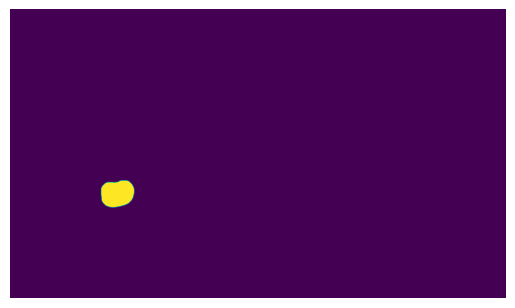

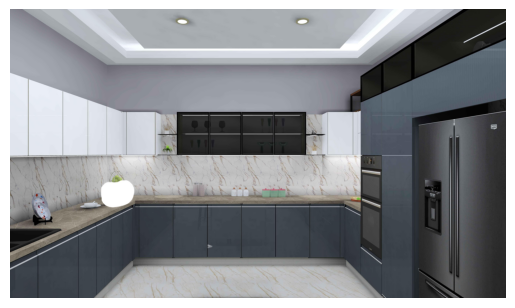

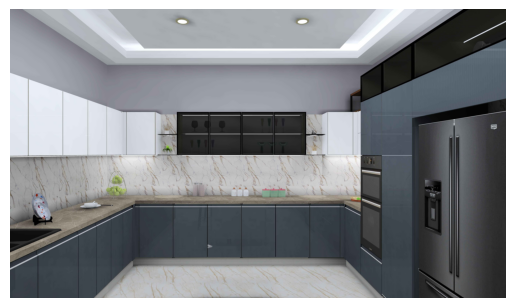

indoor_0521_m_1.jpg | indoor_0521.jpg | indoor_0521_m_1_im.jpg


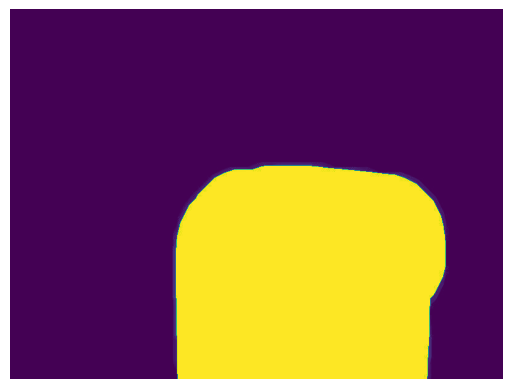

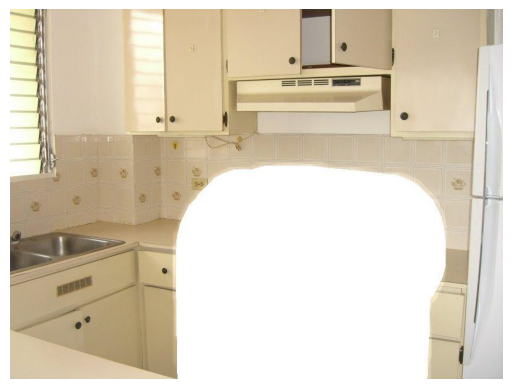

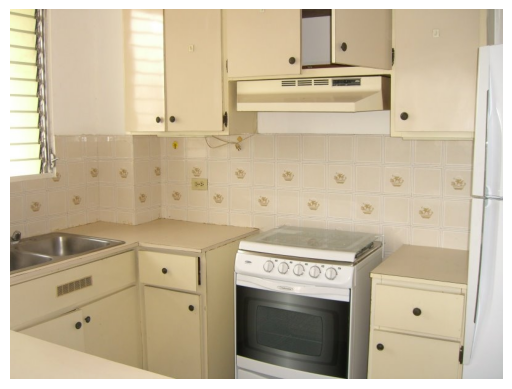

ikea-take-afternoon-tea-to-new-heights__1364319303286-s4_m_2.jpg | ikea-take-afternoon-tea-to-new-heights__1364319303286-s4.jpg | ikea-take-afternoon-tea-to-new-heights__1364319303286-s4_m_2_im.jpg


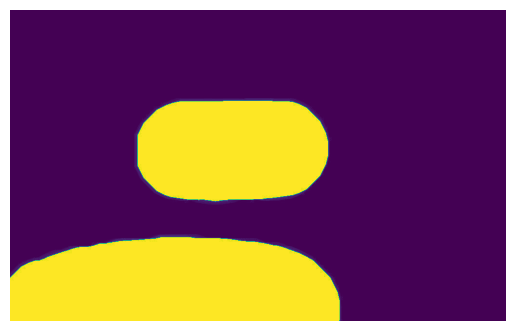

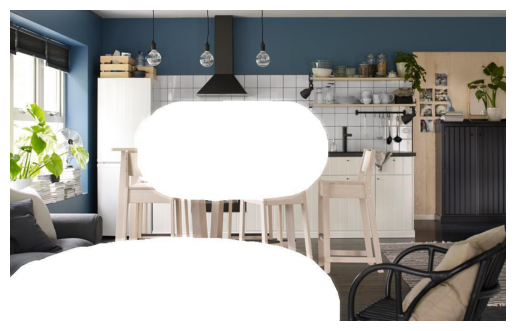

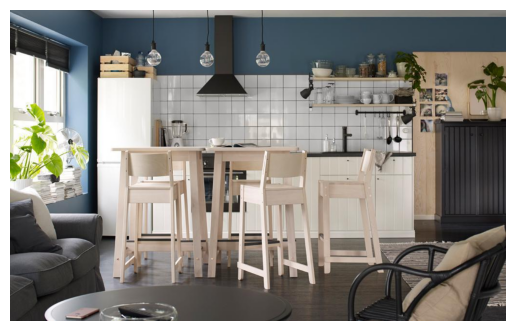

61d6a9debac65d02eea544a8adbb5801_m_2.jpg | 61d6a9debac65d02eea544a8adbb5801.jpg | 61d6a9debac65d02eea544a8adbb5801_m_2_im.jpg


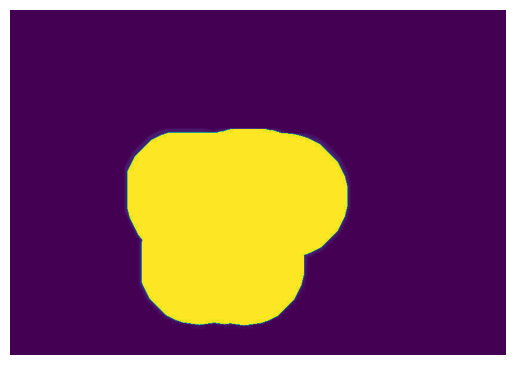

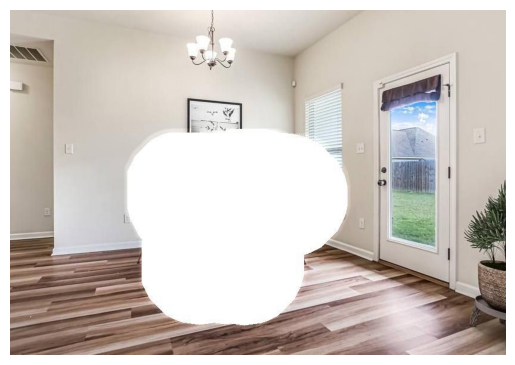

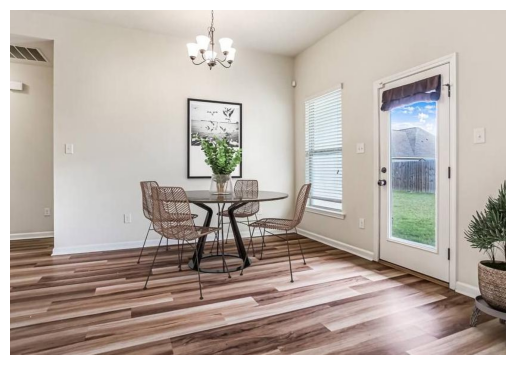

pittsburgh_IMG_4079_m_2.jpg | pittsburgh_IMG_4079.jpg | pittsburgh_IMG_4079_m_2_im.jpg


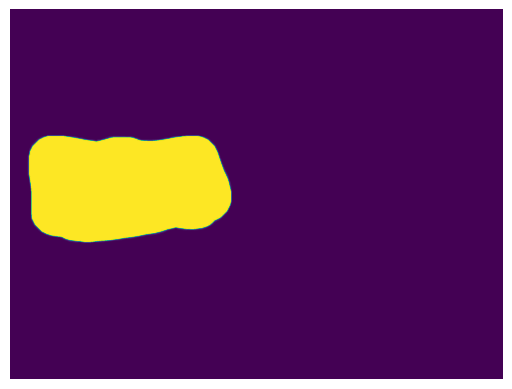

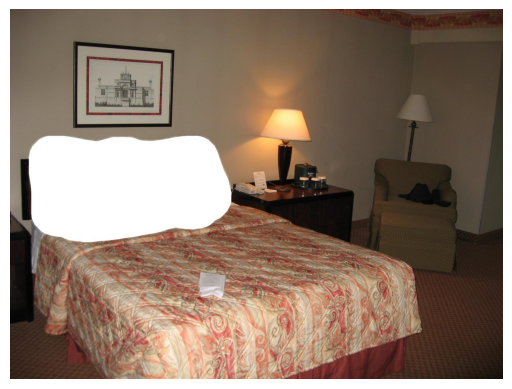

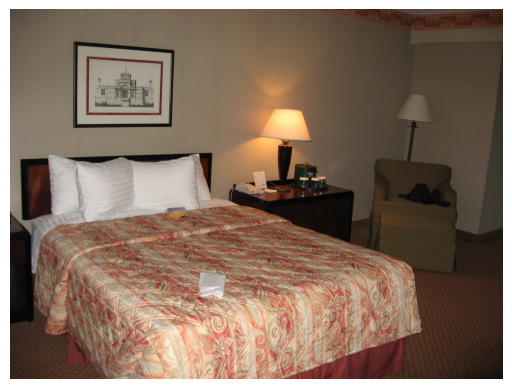

In [71]:
for idx in idx_lst:
    mask_name = mask_names[idx]
    image_name = mask_name.split('_m_')[0] + '.jpg'
    image_mask_name = mask_name[:-4] + '_im.jpg'
    print(mask_name, '|', image_name, '|', image_mask_name)
    mask = Image.open(f'{mask_dir}/{mask_name}')
    plt.imshow(mask)
    plt.axis('off')
    plt.show()
    image_mask = Image.open(f'{image_mask_dir}/{image_mask_name}')
    plt.imshow(image_mask)
    plt.axis('off')
    plt.show()    
    image = Image.open(f'{image_dir}/{image_name}')
    plt.imshow(image)
    plt.axis('off')
    plt.show()  

#### Logic to fine-tune inpainting

In [9]:
!git clone https://github.com/anilbhatt1/interior_design_challenge_022024.git

Cloning into 'interior_design_challenge_022024'...
remote: Enumerating objects: 680, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 680 (delta 110), reused 156 (delta 76), pack-reused 490
Receiving objects: 100% (680/680), 38.41 MiB | 46.87 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [14]:
!accelerate launch '/interior_design_challenge_022024/terrain-diffusion-interior/scripts/train_text_to_image_lora_sd2_inpaint.py' \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-inpainting" \
  --dataset_name="custom" \
  --caption_column="text" \
  --mask_mode="512train-very-large" \
  --mixed_precision="fp16" \
  --train_batch_size=20 \
  --gradient_accumulation_steps=4 \
  --num_train_epochs=3 \
  --checkpointing_steps=495 \
  --learning_rate=1e-06 \
  --lr_scheduler="constant" \
  --seed=2 \
  --validation_epochs=1 \
  --validation_file="/val_images_interio120/validation.jsonl"\
  --output_dir="output" \
  --enable_xformers_memory_efficient_attention \
  --report_to="wandb" \
  --resume_from_checkpoint='latest' \
  --image_dir1="/im_exr_120_jpg/" \
  --image_dir2="/ikea_room_images/" \
  --caption_file_path1='/image_captions.json' \
  --caption_file_path2='/image_captions-ikea.json' \
  --val_image_dir='/val_images_interio120/' \
  --val_image_save_dir='/val_images_save/'

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
03/07/2024 11:26:34 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
 